In [2]:
import numpy as np
import nibabel as nib
from argparse import Namespace

from utils.SAMMed3D_segment_anything.build_sam import sam_model_registry
from classes.SAMClass import SAMWrapper, SAMInferer
import utils.promptUtils as prUt
import utils.analysisUtils as anUt


# Load in model
device = 'cuda'
args = Namespace()
args.image_size = 256
args.sam_checkpoint = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'
args.model_type = 'vit_h'

model = sam_model_registry[args.model_type](args).to(device)

# Load in image, label, prompt
img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
label_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'

img, gt = nib.load(img_path), nib.load(label_path)

# Check if the volume is already in RAS+
if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
    raise RuntimeWarning('Image not in RAS. Consider reorienting here')
    img_ras = nib.as_closest_canonical(volume_img)

if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
    raise RuntimeWarning('Label not in RAS. Consider reorienting here')
    gt_ras = nib.as_closest_canonical(gt)

img, gt = img.get_fdata().astype(np.float32), gt.get_fdata().astype(int)

pts_prompt = prUt.get_pos_clicks2D(gt, 5)

# Perform inference
sam_wrapper = SAMWrapper(model, device)
segmenter = SAMInferer(sam_wrapper, device)

segmentation = segmenter.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

*******interpolate
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth


Performing inference on slices: 100%|██████████| 47/47 [00:04<00:00, 11.31it/s]


0.5417600084337032

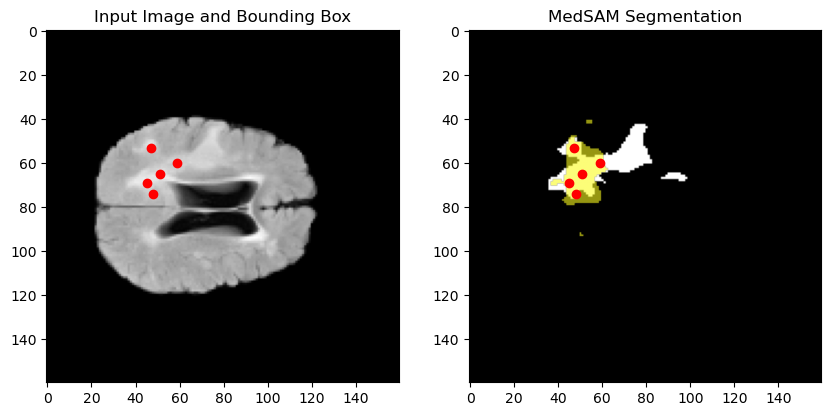

0.5524475524475524

In [2]:
# Slice visualisation:
slice_idx = 60
anUt.show_seg(slice_idx, img, gt, segmentation, pts_prompt= pts_prompt)